In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.amp import autocast, GradScaler # Use 'cuda' specific autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import time # To measure training time

# --- Configuration ---
DATA_DIR = 'dataset/images'  # expects subfolders train/, val/, test/
BATCH_SIZE = 32 # Increased batch size for potentially faster training, adjust based on GPU memory
NUM_EPOCHS = 10
MODEL_SAVE_PATH = 'efficientnet_b0_finetuned.pth' # Path to save the final model

# --- Device Setup ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    # Enable cuDNN benchmark for potentially faster convolutions on fixed input sizes
    torch.backends.cudnn.benchmark = True
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

# --- Determine Number of Classes ---
try:
    train_dir = os.path.join(DATA_DIR, 'train')
    if not os.path.isdir(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    classes = os.listdir(train_dir)
    # Filter out potential hidden files/dirs like .DS_Store
    classes = [d for d in classes if os.path.isdir(os.path.join(train_dir, d))]
    NUM_CLASSES = len(classes)
    if NUM_CLASSES == 0:
        raise ValueError(f"No subdirectories found in {train_dir}. Expected class folders.")
    print(f"Found {NUM_CLASSES} classes: {classes}")
except Exception as e:
    print(f"Error determining number of classes: {e}")
    print("Please ensure DATA_DIR points to a directory containing 'train', 'val', and 'test' subfolders,")
    print("and that 'train' contains one subfolder per class.")
    exit() # Exit if class setup fails

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Found 70 classes: ['Apple', 'Artichoke', 'Balaleet', 'Bamya', 'Banana', 'Basbousa', 'Bell pepper', 'Broccoli', 'Burger', 'Carrot', 'Cheese', 'Crab', 'Cucumber', 'Dajaj_Mahshi', 'Dates_with_tahini', 'Donut', 'Egg', 'Fattoush', 'Fries', 'Gers_Ogaily', 'Grape', 'Harees', 'Hot Dog', 'Hummus', 'Jireesh', 'Kebab', 'khabeesa', 'Kubba', 'laban_drink', 'Labneh', 'Lemon (plant)', 'Lentil_soup', 'Lentil_stew', 'Lobster', 'Luqaimat', 'Majboos_Dajaj', 'Mallooba(Maqluba)', 'Modas_rice', 'Molokhia', 'Muhammara', 'Murabyan', 'Musakhan_Chicken', 'om_ali', 'Orange (fruit)', 'Oyster', 'Peach', 'Pear', 'Pineapple', 'Pizza', 'Plain_white_rice', 'Pomegranate', 'Potato', 'Pumpkin', 'Radish', 'Red_tea_with_mint_or_saffron', 'rice_with_meat', 'Saffron', 'Samosa', 'Sandwich', 'Shrimp', 'Strawberry', 'Tabouleh', 'Taco', 'Tahini', 'Tamarind_juice', 'Tamria(Tamriyeh)', 'Tomato', 'Warak_Enab', 'Watermelon', 'Zaatar']


In [3]:
# --- Preprocessing ---
# Use the recommended weights and transforms for EfficientNet-B0
# --- Preprocessing ---
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
img_size = 224 # Standard EfficientNet-B0 input size from weights.transforms()

# Define separate transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)), # Crop differently each time
    transforms.RandomHorizontalFlip(p=0.5),                  # Flip images horizontally sometimes
    transforms.RandomRotation(degrees=15),                    # Rotate slightly
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Adjust colors
    transforms.ToTensor(),
    # Use normalization parameters from the pre-trained weights
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0) # Optional: Cutout/Random Erasing
])

# Keep validation/test transform simpler (usually matching evaluation protocol)
val_test_transform = weights.transforms() # Use the standard transforms for val/test

In [ ]:
# --- Datasets and Loaders ---
print("Loading datasets...")
try:
    train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
    val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=val_test_transform)
    test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_test_transform)

    # Check if datasets are empty
    if not train_dataset or not val_dataset or not test_dataset:
         raise ValueError("One or more datasets (train, val, test) are empty or could not be loaded.")

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

    # Pin memory for faster CPU to GPU transfers if using CUDA
    pin_memory = True if DEVICE == torch.device("cuda") else False

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=pin_memory)
    print("DataLoaders created.")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure 'train', 'val', and 'test' subdirectories exist in DATA_DIR and contain images.")
    exit()

# --- Model Definition ---
print("Loading EfficientNet-B0 model...")
model = efficientnet_b0(weights=weights)

# Replace the final fully connected layer (classifier)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
model.to(DEVICE)
print(f"Model classifier modified for {NUM_CLASSES} classes.")

Loading datasets...
Train samples: 9277, Val samples: 1070, Test samples: 1424
DataLoaders created.
Loading EfficientNet-B0 model...
Model classifier modified for 70 classes.


In [10]:
import json
import os
from torchvision import datasets

DATA_DIR = 'dataset/images'
MAPPING_SAVE_PATH = 'class_mapping.json'

# Attempt to create train_dataset if not already defined
try:
    if 'train_dataset' not in locals():
        train_path = os.path.join(DATA_DIR, 'train')
        if not os.path.isdir(train_path):
            raise FileNotFoundError(f"Training directory '{train_path}' not found.")
        train_dataset = datasets.ImageFolder(train_path)

    class_mapping = train_dataset.class_to_idx
    print(f"Class mapping: {class_mapping}")

    with open(MAPPING_SAVE_PATH, 'w') as f:
        json.dump(class_mapping, f, indent=4)
    print(f"Mapping saved to: {MAPPING_SAVE_PATH}")

except Exception as e:
    print(f"Error: {e}")

Class mapping: {'Apple': 0, 'Artichoke': 1, 'Balaleet': 2, 'Bamya': 3, 'Banana': 4, 'Basbousa': 5, 'Bell pepper': 6, 'Broccoli': 7, 'Burger': 8, 'Carrot': 9, 'Cheese': 10, 'Crab': 11, 'Cucumber': 12, 'Dajaj_Mahshi': 13, 'Dates_with_tahini': 14, 'Donut': 15, 'Egg': 16, 'Fattoush': 17, 'Fries': 18, 'Gers_Ogaily': 19, 'Grape': 20, 'Harees': 21, 'Hot Dog': 22, 'Hummus': 23, 'Jireesh': 24, 'Kebab': 25, 'Kubba': 26, 'Labneh': 27, 'Lemon (plant)': 28, 'Lentil_soup': 29, 'Lentil_stew': 30, 'Lobster': 31, 'Luqaimat': 32, 'Majboos_Dajaj': 33, 'Mallooba(Maqluba)': 34, 'Modas_rice': 35, 'Molokhia': 36, 'Muhammara': 37, 'Murabyan': 38, 'Musakhan_Chicken': 39, 'Orange (fruit)': 40, 'Oyster': 41, 'Peach': 42, 'Pear': 43, 'Pineapple': 44, 'Pizza': 45, 'Plain_white_rice': 46, 'Pomegranate': 47, 'Potato': 48, 'Pumpkin': 49, 'Radish': 50, 'Red_tea_with_mint_or_saffron': 51, 'Saffron': 52, 'Samosa': 53, 'Sandwich': 54, 'Shrimp': 55, 'Strawberry': 56, 'Tabouleh': 57, 'Taco': 58, 'Tahini': 59, 'Tamarind_jui

In [7]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
# Use AdamW which often works better with transformers and modern architectures
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-2)
# Optional: Learning Rate Scheduler (e.g., reduce on plateau)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
# Factor: Multiplies LR by this (0.1 = reduce to 10%)
# Patience: Number of epochs with no improvement after which LR is reduced.

# --- Mixed Precision Setup ---
# Only use GradScaler if on CUDA
scaler = GradScaler("cuda")
print(f"Mixed precision enabled: {scaler.is_enabled()}")

Mixed precision enabled: True


c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Starting Training ---


[Epoch 1] Train Loss: 3.0170, Accuracy: 0.3483


[Epoch 1] Validation Accuracy: 0.6262
Validation accuracy improved from 0.0000 to 0.6262. Saving best model...


[Epoch 2] Train Loss: 1.3436, Accuracy: 0.6842


[Epoch 2] Validation Accuracy: 0.7766
Validation accuracy improved from 0.6262 to 0.7766. Saving best model...


[Epoch 3] Train Loss: 0.8366, Accuracy: 0.7885


[Epoch 3] Validation Accuracy: 0.8009
Validation accuracy improved from 0.7766 to 0.8009. Saving best model...


[Epoch 4] Train Loss: 0.6150, Accuracy: 0.8378


[Epoch 4] Validation Accuracy: 0.8308
Validation accuracy improved from 0.8009 to 0.8308. Saving best model...


[Epoch 5] Train Loss: 0.4800, Accuracy: 0.8689


[Epoch 5] Validation Accuracy: 0.8393
Validation accuracy improved from 0.8308 to 0.8393. Saving best model...


[Epoch 6] Train Loss: 0.3884, Accuracy: 0.8931


[Epoch 6] Validation Accuracy: 0.8617
Validation accuracy improved from 0.8393 to 0.8617. Saving best model...


[Epoch 7] Train Loss: 0.3150, Accuracy: 0.9111


[Epoch 7] Validation Accuracy: 0.8458


[Epoch 8] Train Loss: 0.2643, Accuracy: 0.9264


[Epoch 8] Validation Accuracy: 0.8607


[Epoch 9] Train Loss: 0.2322, Accuracy: 0.9354


[Epoch 9] Validation Accuracy: 0.8654
Validation accuracy improved from 0.8617 to 0.8654. Saving best model...


[Epoch 10] Train Loss: 0.1974, Accuracy: 0.9457


[Epoch 10] Validation Accuracy: 0.8664
Validation accuracy improved from 0.8654 to 0.8664. Saving best model...

--- Training Finished ---
Total Training Time: 8.72 minutes

--- Plotting Metrics ---
Metrics plot saved as training_validation_metrics.png


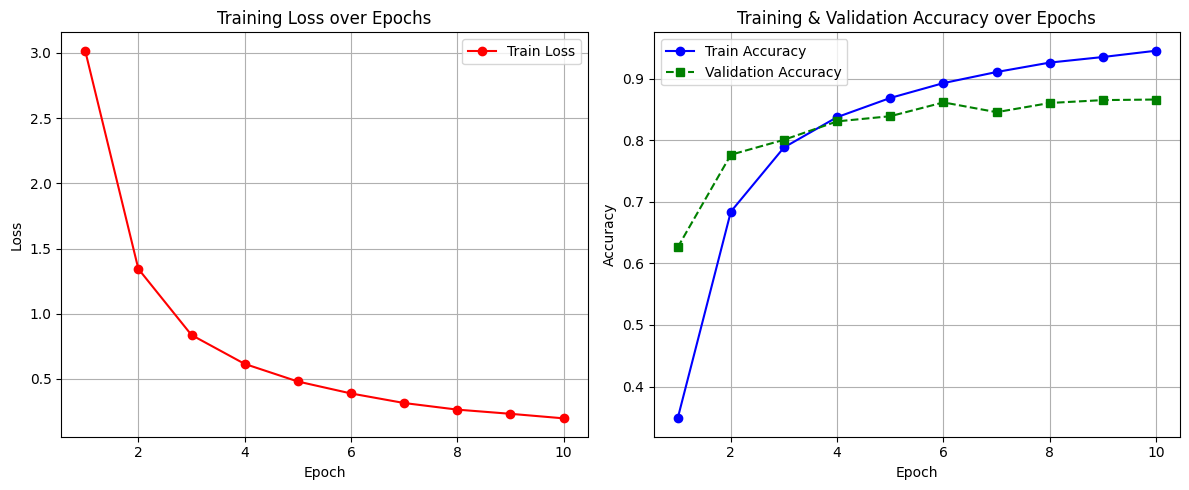

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22336\2738317448.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_lo


--- Evaluating on Test Set ---
Loading best model weights for final testing...


[Epoch Final] Testing (Best Model) Accuracy: 0.8715

Final Test Accuracy (Best Model): 0.8715


In [9]:
# Lists to store metrics for plotting
train_losses, val_accuracies, train_accuracies = [], [], []

# --- Training Function ---
def train_one_epoch(epoch_num):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_num}/{NUM_EPOCHS} [Training]", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        # Use autocast only if on CUDA
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called.
        # Otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        running_loss += loss.item() * inputs.size(0) # Accumulate loss correctly
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar postfix
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        progress_bar.set_postfix(loss=loss.item(), acc=f"{batch_acc:.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f"[Epoch {epoch_num}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

# --- Validation Function ---
@torch.no_grad() # No need to track gradients during evaluation
def evaluate(data_loader, epoch_num=None, phase="Validation"):
    model.eval() # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    desc = f"Epoch {epoch_num if epoch_num else '?'} [{phase}]"
    progress_bar = tqdm(data_loader, desc=desc, leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # Use autocast for potential speedup even during inference on CUDA
        with autocast("cuda"):
            outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        progress_bar.set_postfix(acc=f"{batch_acc:.4f}")


    accuracy = correct_predictions / total_samples
    print(f"[Epoch {epoch_num if epoch_num else 'Final'}] {phase} Accuracy: {accuracy:.4f}")
    return accuracy

# --- Plotting Function ---
def plot_metrics():
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o', linestyle='-', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o', linestyle='-', color='b')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='s', linestyle='--', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.savefig("training_validation_metrics.png") # Save the plot
    print("Metrics plot saved as training_validation_metrics.png")
    plt.show() # Display the plot

# --- Main Execution ---
print("\n--- Starting Training ---")
start_time = time.time()

best_val_acc = 0.0 # Keep track of best validation accuracy for potential early stopping or saving best model

for epoch in range(1, NUM_EPOCHS + 1):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on validation set
    val_acc = evaluate(val_loader, epoch_num=epoch, phase="Validation")
    val_accuracies.append(val_acc)

    # Optional: Implement learning rate scheduling based on validation loss/accuracy
    if scheduler: 
        scheduler.step(val_acc) # Or val_acc if using ReduceLROnPlateau with mode='max'

    # Optional: Save the model checkpoint if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving best model...")
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')


end_time = time.time()
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {(end_time - start_time) / 60:.2f} minutes")

# --- Plot Training and Validation Metrics ---
print("\n--- Plotting Metrics ---")
plot_metrics()

# --- Testing the Model ---
print("\n--- Evaluating on Test Set ---")
# Option 1: Evaluate the final model after all epochs
# test_accuracy = evaluate(test_loader, phase="Testing")

# Option 2: Load the best model (based on validation accuracy) and test that
print("Loading best model weights for final testing...")
try:
    model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
    test_accuracy = evaluate(test_loader, phase="Testing (Best Model)")
    print(f"\nFinal Test Accuracy (Best Model): {test_accuracy:.4f}")
except FileNotFoundError:
    print("Warning: 'best_model.pth' not found. Testing the model from the final epoch.")
    test_accuracy = evaluate(test_loader, phase="Testing (Final Epoch Model)")
    print(f"\nFinal Test Accuracy (Final Epoch Model): {test_accuracy:.4f}")

In [15]:
### Inference on a single image
import os
import json
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image

# --- Configuration ---
MODEL_PATH = 'best_model.pth'
IMAGE_PATH = r'dataset\images\test\Hummus\18.jpg'  # <<<--- CHANGE THIS TO YOUR IMAGE FILE
NUM_CLASSES = 70
MAPPING_JSON_PATH = 'class_mapping.json'  # <<<--- Make sure this path is correct

# --- Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Load Class Names ---
print(f"Loading class mapping from: {MAPPING_JSON_PATH}")
try:
    with open(MAPPING_JSON_PATH, 'r') as f:
        class_to_idx = json.load(f)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    print(f"Loaded {len(idx_to_class)} class names.")
    if len(idx_to_class) != NUM_CLASSES:
        print(f"Warning: Mapping has {len(idx_to_class)} classes, expected {NUM_CLASSES}")
except Exception as e:
    print(f"Failed to load class mapping: {e}")
    exit()

# --- Model Definition ---
print("Loading model...")
model = efficientnet_b0(weights=weights)

# Replace the final fully connected layer (classifier)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
model.to(DEVICE)

# Optional: If you used dropout during training, use the exact same structure
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.4, inplace=True),
#     nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
# )

# --- Load Trained Weights ---
print(f"Loading weights from: {MODEL_PATH}")
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
except Exception as e:
    print(f"Failed to load model weights: {e}")
    exit()
model.to(DEVICE)
model.eval()

# --- Preprocessing ---
preprocess = EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

# --- Prediction Function ---
def predict_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Image load error: {e}")
        return None, None

    input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        conf, idx = torch.max(probs, 1)

    return idx_to_class.get(idx.item(), "Unknown"), conf.item()

# --- Inference ---
if not os.path.exists(IMAGE_PATH):
    print(f"Image path does not exist: {IMAGE_PATH}")
else:
    print(f"Predicting image: {IMAGE_PATH}")
    label, confidence = predict_image(IMAGE_PATH)
    if label:
        print(f"-> Predicted Class: {label}")
        print(f"-> Confidence: {confidence:.4f}")

Using device: cuda
Loading class mapping from: class_mapping.json
Loaded 70 class names.
Loading model...
Loading weights from: best_model.pth
Predicting image: dataset\images\test\Hummus\18.jpg
-> Predicted Class: Labneh
-> Confidence: 0.9968


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22336\3495396984.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=